In [41]:
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

## Let's load the dataset from previos step - after feature engineering

## Setting proportions for Train, Test, Dev

As seen before (in EDA notebook) , the data outcomes in this dataset is balanced  (40% percent malignant vs 60% bening).
So we can straight continue to data splitting from here

In [42]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sb

from sklearn.preprocessing import MinMaxScaler , StandardScaler , RobustScaler

df_mt = pd.read_pickle("IntermidiateData/4_FeatureEngeneering_Cancer_Data.pkl")
# Define the target and feature set
total_samples = df_mt.shape[0]
display(df_mt.head())

X = df_mt.drop(columns=['diagnosis'])
y = df_mt['diagnosis']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True,test_size=0.2, random_state=5)

# Calculate percentages , with each set contains approximately the same percentage of samples of each target class as the complete set.
# X_temp, X_test, y_temp, y_test = train_test_split(X, y, shuffle=True,test_size=0.12, random_state=5)
# X_train, X_dev, y_train, y_dev = train_test_split(X_temp, y_temp, shuffle=True,test_size=0.15, random_state=5)

# Calculate percentages
train_percent = (X_train.shape[0] / total_samples) * 100
#dev_percent = (X_dev.shape[0] / total_samples) * 100
test_percent = (X_test.shape[0] / total_samples) * 100

# Output the sizes of each set in percentages pertaining equal number of outcomes in each set
print(f"Training set size: {train_percent:.2f}%  {X_train.shape[0]} samples")
#print(f"Validation (Dev) set size: {dev_percent:.2f}%  {X_dev.shape[0]} samples")
print(f"Testing set size: {test_percent:.2f}% {X_test.shape[0]} samples")


,perimeter_worst,radius_se,area_se,area_worst,concave_points_worst,concavity_mean,area_mean,concavity_worst,radius_worst,texture_worst,perimeter_mean,compactness_worst,perimeter_se,radius_mean,texture_mean,diagnosis
0,184.60,1.0950,153.40,2019.0,0.2654,0.3001,1001.0,0.7119,25.38,17.33,122.80,0.6656,8.589,17.99,10.38,1
1,158.80,0.5435,74.08,1956.0,0.1860,0.0869,1326.0,0.2416,24.99,23.41,132.90,0.1866,3.398,20.57,17.77,1
2,152.50,0.7456,94.03,1709.0,0.2430,0.1974,1203.0,0.4504,23.57,25.53,130.00,0.4245,4.585,19.69,21.25,1
3,98.87,0.4956,27.23,567.7,0.2575,0.2414,386.1,0.6869,14.91,26.50,77.58,0.8663,3.445,11.42,20.38,1
4,152.20,0.7572,94.44,1575.0,0.1625,0.1980,1297.0,0.4000,22.54,16.67,135.10,0.2050,5.438,20.29,14.34,1


Training set size: 79.96%  455 samples
Testing set size: 20.04% 114 samples


## Hyperparameter tuning with GridSearchCV and cross-validation

In [43]:
# Hyperparameter tuning for the models with GridSearchCV

from sklearn.model_selection import GridSearchCV ,KFold, StratifiedKFold , cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay , classification_report, accuracy_score
import xgboost as xgb

results = []
names = []
best_params = []
models = {}


scores = ["recall" , "f1"]
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_f1"],
        filtered_cv_results["std_test_f1"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

recall_threshold = 0.8
def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.
    The strategy defined here is to filter-out all results below a recall threshold
    of 0.98, rank the remaining by f1 and keep all models with one standard
    deviation of the best by f1. Once these models are selected, we can select the
    fastest model to predict.
    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.
    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores   
    global recall_threshold
    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_recall_cv_results = cv_results_[
        cv_results_["mean_test_recall"] > recall_threshold
    ]

    print(f"Models with a recall higher than {recall_threshold}:")
    print_dataframe(high_recall_cv_results)

    high_recall_cv_results = high_recall_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_f1",
            "std_test_f1",
            "rank_test_recall",
            "rank_test_f1",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_f1_std = high_recall_cv_results["mean_test_f1"].std()
    best_f1 = high_recall_cv_results["mean_test_f1"].max()
    best_f1_threshold = best_f1 - best_f1_std

    high_f1_cv_results = high_recall_cv_results[
        high_recall_cv_results["mean_test_f1"] > best_f1_threshold
    ]
    print(
        "Out of the previously selected high recall models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_f1_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_f1_index = high_f1_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on recall and f1.\n"
        "Its scoring time is:\n\n"
        f"{high_f1_cv_results.loc[fastest_top_recall_high_f1_index]}"
    )

    return fastest_top_recall_high_f1_index

# with k-fold cross validation
# most important scoring = 'recall' since we are interested in minimizing false negatives (i.e. interested in predicting positive class precisely)
# as we also interested in maximizing true negatives we can use f1 score
def estimator_function(models_opt, X , y , scoring = 'f1', folds = 5 , random_state_id = 5):  
    
    for name, model, params in models_opt:
        print(name , model , params) 
        # with k-fold single training set is split into k smaller sets (folds) and then model is trained using k-1 of the 
        # folds as training data and the model is validated on the remaining part 
        # This approach cross-validates estimations and helps to avoid overfit by training repeatedly on different train subsets
        kfold = KFold(n_splits=folds, random_state= random_state_id, shuffle=True)
        #kfold = StratifiedKFold(n_splits=folds, random_state=5, shuffle=True)
        #use all available cores to speed up the process
        grid_search = GridSearchCV(model, params,cv = kfold, refit = True , scoring=scoring, verbose=0)
        grid_search.fit(X, y)
        best_params.append(grid_search.best_params_)         
        results.append(grid_search.best_score_)
        names.append(name)
        models[name]=grid_search.best_estimator_
                
    return names, results , best_params , models


In [44]:
# Here we define the models to be used for binary classification of the data
# and parameters for hyperparameter tuning using GridSearchCV and k-fold cross validation
SVM_params = {'C':[0.001, 0.1, 1, 10 , 100, 200, 300 , 1000], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid']}   # support vector machine
RF_params = {'n_estimators':[10, 100, 1000], 'max_features':['sqrt', 'log2']}      
# RF_params = { 'max_depth':[3,5,10],             # random forest  
#               'n_estimators':[10,100,200],
#               'criterion' : ['gini', 'entropy', 'log_loss'],
#               'max_features':['sqrt', 'log2'],
#               'min_samples_leaf':[1,2,3],
#               'min_samples_split':[1,2,3]}
KNN_params = {'n_neighbors':[3, 5, 7, 9, 11], 'weights':['uniform', 'distance']}    # k-nearest neighbors
DTC_params = {'criterion':['entropy', 'gini'], 'max_depth':[10, 50, 100]}    # decision tree classifier 
LR_params = {'C':[0.001, 0.1, 1, 10, 100], 'penalty': ['l1','l2'], 'solver': ['lbfgs', 'liblinear'] }                                   # logistic regression  
#GB_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # gradient boosting classifier
#AdaBoostClassifier_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # AdaBoost classifier
XGBClassifier_params = {'n_estimators':[50, 100, 500], 'learning_rate':[0.01, 0.1, 1]}  # XGBoost classifier

svm = SVC()
rfc = RandomForestClassifier()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
lr = LogisticRegression()
#gbc = GradientBoostingClassifier()
#adac = AdaBoostClassifier()
xgboostc = xgb.XGBClassifier()
gnb = GaussianNB()

# Create a list of models to tune
models_to_tune = [
    ('SVM', svm, SVM_params),
    ('RF', rfc, RF_params),
    ('KNN', knn, KNN_params),
    ('DTC', dtc, DTC_params),
    ('LR', lr, LR_params),
    #('GB', gbc, GB_params),
    #('AdaBoostClassifier', adac, AdaBoostClassifier_params),
    ('XGBClassifier', xgboostc, XGBClassifier_params),
    ('GaussianNB', gnb, {})]
 

In [45]:
hyperparameters_scoring='f1' # 'f1'
folds_number = 5
random_state_id = 5
names, results , best_params , models  = estimator_function(models_to_tune, X_train , y_train, \
                    folds = folds_number, \
                    scoring=hyperparameters_scoring,\
                    random_state_id = random_state_id)

SVM SVC() {'C': [0.001, 0.1, 1, 10, 100, 200, 300, 1000], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']}
RF RandomForestClassifier() {'n_estimators': [10, 100, 1000], 'max_features': ['sqrt', 'log2']}
KNN KNeighborsClassifier() {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
DTC DecisionTreeClassifier() {'criterion': ['entropy', 'gini'], 'max_depth': [10, 50, 100]}
LR LogisticRegression() {'C': [0.001, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']}
XGBClassifier XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
   

## Models Validation

In [46]:

hyperparameter_tuning_scores_df = pd.DataFrame()
model_params_df = pd.DataFrame()

for name, cv_result , param , model  in zip(names, results, best_params , models):        
        # handle the results (cross-validation scores)        
        dict = {'Model': name, 'Score': cv_result.round(3)}
        row = pd.DataFrame([dict])             
        # append the results to the hyperparameter_tuning_scores_df    
        hyperparameter_tuning_scores_df = pd.concat([hyperparameter_tuning_scores_df, row], axis=0)   
        # handle the best parameters from the grid search
        best_param_dict = {'Model': name, 'Best params': [param]}      
        # convert the dictionary to a DataFrame
        best_param_row = pd.DataFrame(best_param_dict)    
        # append the best parameters to the model_params_df
        model_params_df = pd.concat([model_params_df , best_param_row], axis=0)
        # store the model object in a dictionary for subsequent use

hyperparameter_tuning_scores_df.reset_index(drop=True, inplace=True)
hyperparameter_tuning_scores_df.set_index('Model', inplace=True)
hyperparameter_tuning_scores_df.sort_values(by='Score', ascending=False, inplace=True)
hyperparameter_tuning_scores_df.to_pickle('IntermidiateData/5_Hyperparameter_Tuning_Results.pkl')
model_params_df.set_index('Model', inplace=True)
model_params_df.to_pickle('IntermidiateData/5_Model_Best_Params.pkl')


In [47]:
display(f"Using {hyperparameters_scoring} scoring , the hyperparameter tuning results for the models are as follows")
display(hyperparameter_tuning_scores_df.sort_values(by='Score', ascending=False))
display(model_params_df)

'Using f1 scoring , the hyperparameter tuning results for the models are as follows'

,Score
Model,
XGBClassifier,0.948
LR,0.944
SVM,0.940
RF,0.938
DTC,0.918
GaussianNB,0.907
KNN,0.901


,Best params
Model,
SVM,"{'C': 1, 'kernel': 'linear'}"
RF,"{'max_features': 'log2', 'n_estimators': 100}"
KNN,"{'n_neighbors': 9, 'weights': 'uniform'}"
DTC,"{'criterion': 'entropy', 'max_depth': 50}"
LR,"{'C': 100, 'penalty': 'l1', 'solver': 'libline..."
XGBClassifier,"{'learning_rate': 1, 'n_estimators': 50}"
GaussianNB,{}


In [48]:
# prepare code  measuring performance of the models
from sklearn import metrics

def classificationMetrics(y, yhat):
    res = {'Accuracy': metrics.accuracy_score(y,yhat),
           'Precision': metrics.precision_score(y,yhat),
           'Recall': metrics.recall_score(y,yhat),
           'F1': metrics.f1_score(y,yhat),
           'AUC': metrics.roc_auc_score(y,yhat)
          }
    return res

In [49]:
import matplotlib.pyplot as plt

def test_model(model , model_name, X , y, models_perfmance_df):    
    lrtest_pred = model.predict(X)    # model is a best estimator from GridSearchCV 
    display(f"Performance metrics for {model_name} model")                              
    print(classification_report(y_test, lrtest_pred))
    mod1_dict = {'Model': model_name}
    new_row = pd.DataFrame([{**mod1_dict, **classificationMetrics(y, lrtest_pred) }])
    models_perfmance_df = pd.concat([models_perfmance_df, new_row], ignore_index=True)    
    cm = confusion_matrix(y, lrtest_pred)      
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])

    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    disp.ax_.set_title(f"Confusion Matrix for {model_name}")
    plt.rcParams['figure.figsize'] = [4, 3]
    plt.tight_layout()
    plt.show()    
    return models_perfmance_df


def validate_models(models_perfmance_df, X, y):
    # tests different models with best parameters from hyperparameter tuning and returns the performance metrics
    for model_name in models.keys():
        model_instance = models[model_name]      
        models_perfmance_df  = test_model(model_instance , model_name, X, y, models_perfmance_df)    

    models_perfmance_df.reset_index(drop=True, inplace=True)
    models_perfmance_df.set_index('Model', inplace=True)
    return models_perfmance_df

We want to reduce a number of false negatives without necessary reducing the number of false positives , as in medical classification model false negative errors are very costly.
Instead , cost of false positive is not as high and thus precision metrics is less important. 
Thus , to choose rigth model we will look for a model with high recall value (good at correctly identifying true positives) plus good precision (good at positive predictions in general). 
==> F1 - a harmonic mean of recall and precision is a good metrics to consider.

In this context , SVC has best scores - highest accuracy , precision , F1 and recall , no overfitting.
Next best is XGBoostClassifier

'Validation : models confusion matrixes:'

'Performance metrics for SVM model'

              precision    recall  f1-score   support

           0       0.97      0.98      0.98        66
           1       0.98      0.96      0.97        48

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



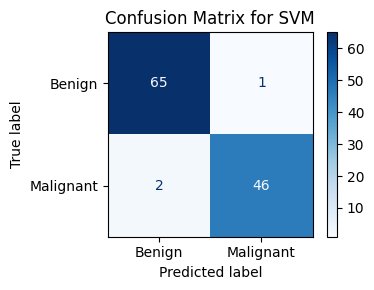

'Performance metrics for RF model'

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        66
           1       1.00      0.92      0.96        48

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



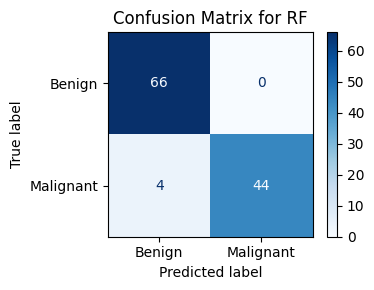

'Performance metrics for KNN model'

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        66
           1       1.00      0.85      0.92        48

    accuracy                           0.94       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.94      0.94      0.94       114



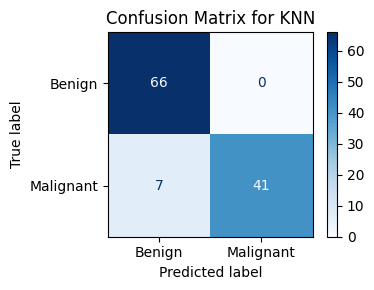

'Performance metrics for DTC model'

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.96      0.94      0.95        48

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



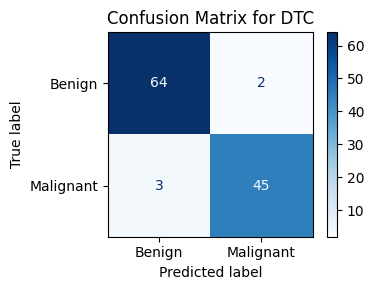

'Performance metrics for LR model'

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        66
           1       0.96      0.96      0.96        48

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114



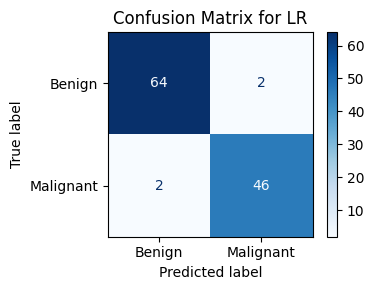

'Performance metrics for XGBClassifier model'

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        66
           1       1.00      0.96      0.98        48

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



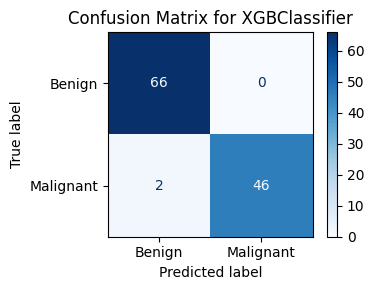

'Performance metrics for GaussianNB model'

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.96      0.94      0.95        48

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



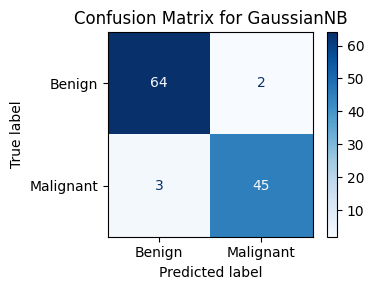

In [50]:
# We use test dataset for validation of the models , and also for the eveluation (fine tuning) of the models
# This is because our dataset is very small. To compensate , we can use cross-validation  where possibly.

# models_perfmance_df_val = pd.DataFrame()
# display("Validation : models confusion matrixes:")
# models_perfmance_df_val = validate_models(models_perfmance_df_val,X_dev, y_dev)

models_perfmance_df_test = pd.DataFrame()
display("Validation : models confusion matrixes:")
models_perfmance_df_test = validate_models(models_perfmance_df_test,X_test, y_test)

In [51]:
display(models_perfmance_df_test.sort_values(by='F1', ascending=False).style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
XGBClassifier,0.982456,1.000000,0.958333,0.978723,0.979167
SVM,0.973684,0.978723,0.958333,0.968421,0.971591
LR,0.964912,0.958333,0.958333,0.958333,0.964015
RF,0.964912,1.000000,0.916667,0.956522,0.958333
DTC,0.956140,0.957447,0.937500,0.947368,0.953598
GaussianNB,0.956140,0.957447,0.937500,0.947368,0.953598
KNN,0.938596,1.000000,0.854167,0.921348,0.927083


### Model Selection
Best performance is shown by two models:   

*SVM             with recall (on malignant label) of 96% and f1 (on malignant label) of 97%      
*XGBClassifier   with recall (on malignant label) of 96% and f1 (on malignant label) of 98%

Let's try to fine tune and then decide on the model

## Fine tune SVC

Tecniques: GridSearch ,cross-validation and custom refit function that returns fastest model chosen from all those with minimal recall threshold of 0.9 and within one standard deviation of the best by f1.

In [52]:
# fine tune models parameters
# use customized refit_strategy to select the best estimator
def fine_tune_model(model , X_train, y_train, X_test, y_test, params):
    grid_search = GridSearchCV(model, params, refit = refit_strategy, scoring= scores, verbose= 1, n_jobs= -1)                                              
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters for the { type(model).__name__  } after fine tuning: {best_params}")
    y_test_pred = grid_search.best_estimator_.predict(X_test)
    cls_rprt = classificationMetrics(y_test, y_test_pred)
    print(classification_report(y_test, y_test_pred))
    print(cls_rprt)
    display(confusion_matrix(y_test, y_test_pred))
    return grid_search.best_estimator_ , cls_rprt


In [53]:
tuned_parameters_SVM = [
   { "kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100,200,300,1000]} ,
   { "kernel": ["poly"], "C": [1, 10, 100,1000]},
]
estimator_SVM , clf_report_SVM = fine_tune_model(SVC(), X_train, y_train, X_test, y_test , params = tuned_parameters_SVM)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


All grid-search results:
precision: 0.881 (±0.050), recall: 0.903 (±0.059), for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.904 (±0.053), recall: 0.873 (±0.078), for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 0.858 (±0.057), recall: 0.879 (±0.096), for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.900 (±0.046), recall: 0.879 (±0.063), for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 0.858 (±0.057), recall: 0.879 (±0.096), for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.891 (±0.071), recall: 0.866 (±0.073), for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 0.858 (±0.057), recall: 0.879 (±0.096), for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.864 (±0.061), recall: 0.842 (±0.051), for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 0.917 (±0.057), recall: 0.891 (±0.078), for {'C': 1, 'kernel': 'linear'}
precision: 0.918 (±0.028), recall: 0.897 (±0.049), for {'C': 10, 'kernel': 'linear'}
precision: 0.9

array([[65,  1],
       [ 1, 47]])

#### SVM after fine tuning improves a little , its perfomance is now better then the performance of XGBClassifier
(performance improvements:
 recal , F1 and precision of the 'mailgnant' class label is now 98% , instead of 97% previously)
           
                   precision    recall  f1-score   support
           0       0.98      0.98      0.98        66
           1       0.98      0.98      0.98        48
    accuracy                           0.98       114
    macro avg       0.98      0.98     0.98       114
    weighted avg    0.98      0.98     0.98       114

   


{'Accuracy': 0.9824561403508771, 'Precision': 0.9791666666666666, 'Recall': 0.9791666666666666, 'F1': 0.9791666666666666, 'AUC': 0.9820075757575757}

## Fine tune XGBClassifier

In [54]:
tuned_parameters_XGBClassifier = {
    #'max_depth': [4,6,8,10],
    'n_estimators': [200, 300, 700],  
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.5],
    'lambda': [1, 1.5, 2]
}

estimator_xgbc , clf_report_xgbc = fine_tune_model(xgb.XGBClassifier() , X_train, y_train, X_test, y_test , params = tuned_parameters_XGBClassifier)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
All grid-search results:
precision: 0.943 (±0.026), recall: 0.927 (±0.062), for {'alpha': 0, 'colsample_bytree': 0.7, 'gamma': 0, 'lambda': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.7}
precision: 0.947 (±0.038), recall: 0.927 (±0.056), for {'alpha': 0, 'colsample_bytree': 0.7, 'gamma': 0, 'lambda': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.8}
precision: 0.938 (±0.032), recall: 0.933 (±0.065), for {'alpha': 0, 'colsample_bytree': 0.7, 'gamma': 0, 'lambda': 1, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.9}
precision: 0.940 (±0.027), recall: 0.927 (±0.062), for {'alpha': 0, 'colsample_bytree': 0.7, 'gamma': 0, 'lambda': 1, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
precision: 0.946 (±0.030), recall: 0.927 (±0.056), for {'alpha': 0, 'colsample_bytree': 0.7, 'gamma': 0, 'lambda': 1, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.8}
precision

array([[66,  0],
       [ 2, 46]])

#### XGBClassifier after fine tuning - no improvement 
Its Recall value on 'malignant' detection is 96% vs SVM with 98%
        
           precision    recall  f1-score   support
           0       0.97      1.00      0.99        66
           1       1.00      0.96      0.98        48

    accuracy                               0.98       114
    macro avg          0.99      0.98      0.98       114
    weighted avg       0.98      0.98      0.98       114


{'Accuracy': 0.9824561403508771, 'Precision': 1.0, 'Recall': 0.9583333333333334, 'F1': 0.9787234042553191, 'AUC': 0.9791666666666667}

## Final model selection
SVM with scores of 98%

                  precision    recall  f1-score   support
           0       0.98      0.98      0.98        66
           1       0.98      0.98      0.98        48
    accuracy                           0.98       114
    macro avg       0.98      0.98     0.98       114
    weighted avg    0.98      0.98     0.98       114

## Save the work

In [55]:
evaluation_scoring = 'F1'
display(f"Validation set : models performance metrics sorted by {evaluation_scoring}")
# display(models_perfmance_df_val.sort_values(by=evaluation_scoring, ascending=False).style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))
# models_perfmance_df_val.to_excel('IntermidiateData/5_FinalValidationScores.xlsx')
# Update final evaluation scores - with fine tuning results
models_perfmance_df_test.loc['SVM']['Accuracy'] = clf_report_SVM['Accuracy']
models_perfmance_df_test.loc['SVM']['Precision'] = clf_report_SVM['Precision']
models_perfmance_df_test.loc['SVM']['Recall'] = clf_report_SVM['Recall']
models_perfmance_df_test.loc['SVM']['F1'] = clf_report_SVM['F1']
models_perfmance_df_test.loc['SVM']['AUC'] = clf_report_SVM['AUC']

models_perfmance_df_test.loc['XGBClassifier']['Accuracy'] = clf_report_xgbc['Accuracy']
models_perfmance_df_test.loc['XGBClassifier']['Precision'] = clf_report_xgbc['Precision']
models_perfmance_df_test.loc['XGBClassifier']['Recall'] = clf_report_xgbc['Recall']
models_perfmance_df_test.loc['XGBClassifier']['F1'] = clf_report_xgbc['F1']
models_perfmance_df_test.loc['XGBClassifier']['AUC'] = clf_report_xgbc['AUC']

display(models_perfmance_df_test.sort_values(by=evaluation_scoring, ascending=False).style.set_properties(**{'text-align': 'left'}).set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}]))
models_perfmance_df_test.sort_values(by=evaluation_scoring, ascending=False).to_excel('IntermidiateData/5_FinalEvaluationScores.xlsx')



'Validation set : models performance metrics sorted by F1'

,Accuracy,Precision,Recall,F1,AUC
Model,,,,,
SVM,0.982456,0.979167,0.979167,0.979167,0.982008
XGBClassifier,0.982456,1.000000,0.958333,0.978723,0.979167
LR,0.964912,0.958333,0.958333,0.958333,0.964015
RF,0.964912,1.000000,0.916667,0.956522,0.958333
DTC,0.956140,0.957447,0.937500,0.947368,0.953598
GaussianNB,0.956140,0.957447,0.937500,0.947368,0.953598
KNN,0.938596,1.000000,0.854167,0.921348,0.927083
